In [1]:
import numpy as np
import pylab as plt
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import recall_score,precision_score,classification_report,confusion_matrix,matthews_corrcoef

import ahunt as ah

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

rept = 'try: {:3d}/{:3d}  <{:10s}> | night: {:3d}/{:3d}  <{:10s}> | L2Y map: {} | Interest: {}'

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
fname = 'mnist'
ntry = 3
prefix = 'res/'
postfix = 'plan2-{}'.format(ntry)
outfile = '{}{}-{}'.format(prefix,fname,postfix)

n_night = 15
n_questions = 4 # can be an integer or an array of numbers np.random.randint(3,7,n_night)
epochs = 3

noise = 0.1
ivc = 0
check_c = True
nightly=False
givey = True
nmin_pre=None
save_latent = False

path = '/home/vafaeisa/scratch/datasets/prepared/{}.npz'.format(fname)
x0,y0,int_mapper,lbl_mapper = ah.load_npz(path,verbose=1)
x0 = x0/x0.max()

outlier_ind = 5
pre_data_config = {0:500,1:900}
obs_plan = 30*[{0:170,1:200,outlier_ind:6}]

plan_tot = [pre_data_config]+obs_plan

#fig,ax = plt.subplots(1,1,figsize=(14,5))
#population_by_group = ah.plot_population(plan_tot,ax=ax)
#ax.set_xlabel('nights',fontsize=15)
#ax.set_ylabel('density of class',fontsize=15)
#ax.set_xlim(0,n_night)
#plt.legend(fontsize=15)
#plt.subplots_adjust(left=0.05, bottom=0.1, right=0.99, top=0.99, wspace=None, hspace=None)
#plt.savefig('config_{}.jpg'.format(prefix),dpi=150)
#plt.close()


aug = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.04,
    height_shift_range=0.04,
#     brightness_range=0.01,
#        shear_range=0.0,
    zoom_range=0.04,
#     horizontal_flip=True,
#     vertical_flip=True,
    fill_mode="nearest")


nmin,outlier_ind0,pre_data_config0,obs_plan0 = ah.planmaker(path,nmin_pre=nmin_pre,outlier_ind=outlier_ind)
n_questions0 = int(0.7*nmin)

if n_questions is None: n_questions=n_questions0
if outlier_ind is None: outlier_ind=outlier_ind0
if pre_data_config is None: pre_data_config=pre_data_config0
if obs_plan is None: obs_plan=obs_plan0
print(pre_data_config)
print(obs_plan[0])

if type(n_questions) is int or type(n_questions) is float:
    if n_questions==1 and type(n_questions) is float:
        assert 0,'Warning, when you choose 1, it should be integer.'
    n_questions = n_night*[n_questions]

if x0.ndim==3:
    n_tot,lx,ly = x0.shape
#     x = x.reshape(n_tot,lx*ly)
    x0 = x0[:,:,:,None]
    nch = 1
elif x0.ndim==4:
    n_tot,lx,ly,nch = x0.shape

if noise!=0:
    x0 += np.random.normal(0,noise,x0.shape)
n_class,class_labels, nums = ah.describe_labels(y0,verbose=0)

(70000, 28, 28) (70000,)
labels/numbers are:
	class0   /  6903
 	class1   /  7877
 	class2   /  6990
 	class3   /  7141
 	class4   /  6824
 	class5   /  6313
 	class6   /  6876
 	class7   /  7293
 	class8   /  6825
 	class9   /  6958

outlier is  class5
{0: 500, 1: 900}
{0: 170, 1: 200, 5: 6}


In [ ]:
res_alls = []
nq_alls = []
res5s = []
res6s = []
    

for nt in range(ntry):
    res1 = []
    res2 = []
    res3 = []
    res4 = []
    res5 = []
    res6 = []
    
    # if save_latent:
    z_mus = []
    lbls = []
    nq_all = []

    x,y = ah.shuffle_data(x0,y0)
    # data 0
    x, y, x_pre, y_pre = ah.data_prepare(x,y,pre_data_config)
    # observation
    obs = ah.Observetory(obs_plan,x,y)

    y = y_pre if givey else None

    ahunt = ah.AHunt(x_pre, y=y, interest=None, aug=aug)
    ahunt.fit(epochs=epochs,ivc=ivc)  

    ahunt0 = ah.AHunt(x_pre, y=y, interest=None, aug=aug)
    ahunt0.fit(epochs=epochs,ivc=ivc)

    if n_night is None: n_night = obs.n_plan
        
    phc = ah.PredictionHistoryChecker()

    for night in range(n_night):
        report = rept.format(nt,ntry,int(10*nt/ntry)*'=',
                             night,n_night,int(10*night/n_night)*'=',
                             ahunt.lm.l2y,ahunt.get_interest())
        print(report,end='\r')
        x_obs,y_obs = obs.new_obs(safemode=1,nightly=nightly)
    #     describe_labels(y_obs,verbose=1)

        out_obs = y_obs==outlier_ind
        y_true = out_obs.astype(int)
        n_anomaly = np.sum(out_obs)
        ano_inds = np.argwhere(out_obs)[:,0]

        # Method 1
        scr_ano = ah.iforest_get_anomalies(x_obs.reshape(-1,lx*ly*nch))
        trsh = np.sort(scr_ano)[-n_anomaly-1]
        y_pred = scr_ano>trsh

        rws = ah.rws_score(out_obs,scr_ano)
        rc = recall_score(y_true,y_pred)
        pr = precision_score(y_true,y_pred)
        mcc = matthews_corrcoef(y_true,y_pred)
        inds,true_guess = ah.get_tguess(n_questions[night],scr_ano,ano_inds)
        res1.append([rws,rc,pr,mcc,true_guess])

        # Method 2
        z_mu = ahunt0.to_latent(x_obs)
        scr_ano = ah.iforest_get_anomalies(z_mu)
        trsh = np.sort(scr_ano)[-n_anomaly-1]
        y_pred = scr_ano>trsh
        rws = ah.rws_score(out_obs,scr_ano)
        rc = recall_score(y_true,y_pred)
        pr = precision_score(y_true,y_pred)
        mcc = matthews_corrcoef(y_true,y_pred)
        inds,true_guess = ah.get_tguess(n_questions[night],scr_ano,ano_inds)
        res2.append([rws,rc,pr,mcc,true_guess])

        # Method 3
        z_mu = ahunt.to_latent(x_obs)
        if save_latent:
            z_mus.append(z_mu)
            lbls.append(y_obs)
        scr_ano = ah.iforest_get_anomalies(z_mu)
        trsh = np.sort(scr_ano)[-n_anomaly-1]
        y_pred = scr_ano>trsh
        rws = ah.rws_score(out_obs,scr_ano)
        rc = recall_score(y_true,y_pred)
        pr = precision_score(y_true,y_pred)
        mcc = matthews_corrcoef(y_true,y_pred)

        true_guess = phc.get_tguess(n_questions[night],scr_ano,ano_inds,x_obs)
        res3.append([rws,rc,pr,mcc,true_guess])

        # Method 4
        true_guess = ahunt.human_call(x_obs,y_obs,n_questions[night])
        nq_all.append(len(ahunt.inds_all))

        ahunt.fit(epochs=epochs,ivc=ivc)
        if ahunt.n_class==4:
            ahunt.set_interest('5')
    #     model_par.append(stds_model(ahunt.clf))
        scr_ano = ahunt.predict(x_obs)
        trsh = np.sort(scr_ano)[-n_anomaly-1]
        y_pred = scr_ano>trsh
        rws = ah.rws_score(out_obs,scr_ano)
        rc = recall_score(y_true,y_pred)
        pr = precision_score(y_true,y_pred)
        mcc = matthews_corrcoef(y_true,y_pred)
        res4.append([rws,rc,pr,mcc,true_guess])

        if check_c and not nightly and night%5==4:

            ahunt5 = ah.AHunt(x_pre, y=y_pre, interest=None, aug=aug)
            true_guess = ahunt5.human_call(x_obs,y_obs,np.sum(nq_all))
            ahunt5.fit(epochs=night*epochs,ivc=ivc)
            if ahunt5.n_class==4:
                ahunt5.set_interest('5')

            out_obs = y_obs==outlier_ind
            y_true = out_obs.astype(int)
            n_anomaly = np.sum(out_obs)

            scr_ano = ahunt5.predict(x_obs)
            trsh = np.sort(scr_ano)[-n_anomaly-1]
            y_pred = scr_ano>trsh
            rws = ah.rws_score(out_obs,scr_ano)
            rc = recall_score(y_true,y_pred)
            pr = precision_score(y_true,y_pred)
            mcc = matthews_corrcoef(y_true,y_pred)

            res5.append([rws,rc,pr,mcc,true_guess])


            ahunt6 = ah.AHunt(x_pre, y=y_pre, interest=None, aug=aug,reserved_classes=[])
            true_guess = ahunt6.human_call(x_obs,y_obs,np.sum(nq_all))
            if true_guess==0:
                res6.append([0,0,0,0,0])
            else:

                ahunt6.fit(epochs=night*epochs,ivc=ivc)

                out_obs = y_obs==outlier_ind
                y_true = out_obs.astype(int)
                n_anomaly = np.sum(out_obs)

                scr_ano = ahunt6.predict(x_obs)
                trsh = np.sort(scr_ano)[-n_anomaly-1]
                y_pred = scr_ano>trsh
                rws = ah.rws_score(out_obs,scr_ano)
                rc = recall_score(y_true,y_pred)
                pr = precision_score(y_true,y_pred)
                mcc = matthews_corrcoef(y_true,y_pred)

                res6.append([rws,rc,pr,mcc,true_guess])
    
    res_alls.append([res1,res2,res3,res4])
    nq_alls.append(nq_all)
    res5s.append(res5)
    res6s.append(res6)
    
res_all = np.array(res_alls)
nq_all = np.array(nq_alls)
res5 = np.array(res5s)
res6 = np.array(res6s)

for i in range(4):
    res_all[:,i,:,4] = 100*res_all[:,i,:,4]/nq_all

In [ ]:
n_night = res_all.shape[2]
xx = np.arange(res_all.shape[2]/res5.shape[2])
xx = xx/xx.max()*n_night

cl = 95
alpha = 0.2
fig,axs = plt.subplots(2,2,figsize=(14,11))

lbls = ['iforest_raw','iforest_latent-static','iforest_latent-learning','AHunt']
clrs = ['k','r','g','b']
metric_names = ['RWS','True candidates (%)','recall','MCC']


for j,jj in enumerate([0,4,1,3]):
    ax = axs[j//2,j%2]
    for  i in range(4):
        ah.analyze_plot(ax, metric=res_all[:,i,:,jj], cl=cl, clr=clrs[i], label=lbls[i], alpha=alpha)

    ah.analyze_plot(ax, metric=res5[:,:,jj], x=xx, cl=cl, clr='orange', label='classifier1', alpha=alpha)
    ah.analyze_plot(ax, metric=res6[:,:,jj], x=xx, cl=cl, clr='yellow', label='classifier2', alpha=alpha)

    ax.set_xlabel('epoch',fontsize=15)
    ax.set_ylabel(metric_names[j],fontsize=15)
    ax.set_xlim(0,n_night-1)
    if jj==4:
        ax.set_ylim(0,102)
    else:
        ax.set_ylim(0,1.05)
    
ax.legend(fontsize=13)
plt.subplots_adjust(left=0.05, bottom=0.06, right=0.99, top=0.99, wspace=None, hspace=None)
# plt.savefig('result_{}-{}.jpg'.format(fname,pln),dpi=150)

# Attention plan 

- the 1t anomaly is half imporant as the 2nd
- reseved class is 5 time impatnt than the first
- 2nd anomaly from 10th night
- keep the reserved class
- ratio on the two anomalies

In [3]:
ntry = 3
n_night = 30
n_questions = 10 # can be an integer or an array of numbers np.random.randint(3,7,n_night)
pre_data_config = {0:500,1:600}
obs_plan = 10*[{0:170,1:200,5:6}]+20*[{0:170,1:200,5:6,9:10}]

In [4]:
path = '/home/vafaeisa/scratch/datasets/prepared/{}.npz'.format(fname)
x0,y0,int_mapper,lbl_mapper = ah.load_npz(path,verbose=1)
x0 = x0/x0.max()

plan_tot = [pre_data_config]+obs_plan

aug = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.04,
    height_shift_range=0.04,
    zoom_range=0.04,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest")

print(pre_data_config)
print(obs_plan[0])

if type(n_questions) is int or type(n_questions) is float:
    if n_questions==1 and type(n_questions) is float:
        assert 0,'Warning, when you choose 1, it should be integer.'
    n_questions = n_night*[n_questions]

if x0.ndim==3:
    n_tot,lx,ly = x0.shape
#     x = x.reshape(n_tot,lx*ly)
    x0 = x0[:,:,:,None]
    nch = 1
elif x0.ndim==4:
    n_tot,lx,ly,nch = x0.shape

if noise!=0:
    x0 += np.random.normal(0,noise,x0.shape)
n_class,class_labels, nums = ah.describe_labels(y0,verbose=0)

(70000, 28, 28) (70000,)
labels/numbers are:
	class0   /  6903
 	class1   /  7877
 	class2   /  6990
 	class3   /  7141
 	class4   /  6824
 	class5   /  6313
 	class6   /  6876
 	class7   /  7293
 	class8   /  6825
 	class9   /  6958

{0: 500, 1: 600}
{0: 170, 1: 200, 5: 6}


In [5]:
# x,y = ah.shuffle_data(x0,y0)
# x, y, x_pre, y_pre = ah.data_prepare(x,y,pre_data_config)
# obs = ah.Observetory(obs_plan,x,y)
# y = y_pre if givey else None
# ahunt = ah.AHunt(x_pre, y=y, interest=None, aug=aug)
# ahunt.fit(epochs=epochs,ivc=ivc)  

# if n_night is None: n_night = obs.n_plan

# phc = ah.PredictionHistoryChecker()
# for night in range(n_night):
#     x_obs,y_obs = obs.new_obs(safemode=1,nightly=nightly)
#     true_guess = ahunt.human_call(x_obs,y_obs,n_questions[night])
#     nq_all = len(ahunt.inds_all)
# #     print(nq_all,true_guess)
#     ahunt.fit(epochs=epochs,ivc=ivc)
#     if not '5' in ahunt.lm.yints:
#         ahunt.set_interest({'r1':1})
#     elif '5' in ahunt.lm.yints and not '9' in ahunt.lm.yints:
#         ahunt.set_interest({'r1':5/6,'5':1/6})
#     elif '5' in ahunt.lm.yints and '9' in ahunt.lm.yints:
#         ahunt.set_interest({'r1':5/8,'5':1/8,'9':2/8})
#     else:
#         assert 0,'WHAT?!!!'

In [6]:
res_alls = []
nq_alls = []
res5s = []
res6s = []
    

for nt in range(ntry):
    res1 = []
    res2 = []

    # if save_latent:
    z_mus = []
    lbls = []
    nq_all = []

    x,y = ah.shuffle_data(x0,y0)
    # data 0
    x, y, x_pre, y_pre = ah.data_prepare(x,y,pre_data_config)
    # observation
    obs = ah.Observetory(obs_plan,x,y)

    y = y_pre if givey else None

    ahunt = ah.AHunt(x_pre, y=y, interest=None, aug=aug)
    ahunt.fit(epochs=epochs,ivc=ivc)  

    ahunt0 = ah.AHunt(x_pre, y=y, interest=None, aug=aug)
    ahunt0.fit(epochs=epochs,ivc=ivc)

    if n_night is None: n_night = obs.n_plan
        
    phc = ah.PredictionHistoryChecker()

    for night in range(n_night):
        report = rept.format(nt+1,ntry,int(10*(nt+1)/ntry)*'=',
                             night+1,n_night,int(10*(night+1)/n_night)*'=',
                             ahunt.lm.l2y,ahunt.get_interest())
        print(report,end='\r')
        x_obs,y_obs = obs.new_obs(safemode=1,nightly=nightly)
    #     describe_labels(y_obs,verbose=1)

        # Method 4
        true_guess = ahunt.human_call(x_obs,y_obs,n_questions[night])
        nq_all = len(ahunt.inds_all)

        ahunt.fit(epochs=epochs,ivc=ivc)
#         if ahunt.n_class==4:
#             ahunt.set_interest('5')
        if not '5' in ahunt.lm.yints:
            ahunt.set_interest({'r1':1})
        elif '5' in ahunt.lm.yints and not '9' in ahunt.lm.yints:
            ahunt.set_interest({'r1':5/6,'5':1/6})
        elif '5' in ahunt.lm.yints and '9' in ahunt.lm.yints:
            ahunt.set_interest({'r1':5/8,'5':1/8,'9':2/8})
        else:
            assert 0,'WHAT?!!!'

    #     model_par.append(stds_model(ahunt.clf))
        if '5' in ahunt.lm.yints:
            outlier_ind = 5
            out_obs = y_obs==outlier_ind
            y_true = out_obs.astype(int)
            n_anomaly = np.sum(out_obs)
            ano_inds = np.argwhere(out_obs)[:,0]
            
            scr_ano = ahunt.predict(x_obs,'5')
            trsh = np.sort(scr_ano)[-n_anomaly-1]
            y_pred = scr_ano>trsh
            rws = ah.rws_score(out_obs,scr_ano)
            rc = recall_score(y_true,y_pred)
            pr = precision_score(y_true,y_pred)
            mcc = matthews_corrcoef(y_true,y_pred)
#             nqs = ahunt.nqs[ahunt.lm.l2y['5']]
            res1.append([rws,rc,pr,mcc,100*true_guess/nq_all])
        else:
            res1.append(5*[0])
        
    #     model_par.append(stds_model(ahunt.clf))
        if '9' in ahunt.lm.yints:
            outlier_ind = 9
            out_obs = y_obs==outlier_ind
            y_true = out_obs.astype(int)
            n_anomaly = np.sum(out_obs)
            ano_inds = np.argwhere(out_obs)[:,0]
            
            scr_ano = ahunt.predict(x_obs,'9')
            trsh = np.sort(scr_ano)[-n_anomaly-1]
            y_pred = scr_ano>trsh
            rws = ah.rws_score(out_obs,scr_ano)
            rc = recall_score(y_true,y_pred)
            pr = precision_score(y_true,y_pred)
            mcc = matthews_corrcoef(y_true,y_pred)
#             nqs = ahunt.nqs[ahunt.lm.l2y['9']]
            res2.append([rws,rc,pr,mcc,100*true_guess/nq_all])
        else:
            res2.append(5*[0])
        
    res_alls.append([res1,res2])
    nq_alls.append(nq_all)
    
res_all = np.array(res_alls)
nq_alls = np.array(nq_alls)

# for i in range(2):
#     res_all[:,i,:,4] = 100*res_all[:,i,:,4]/nq_all

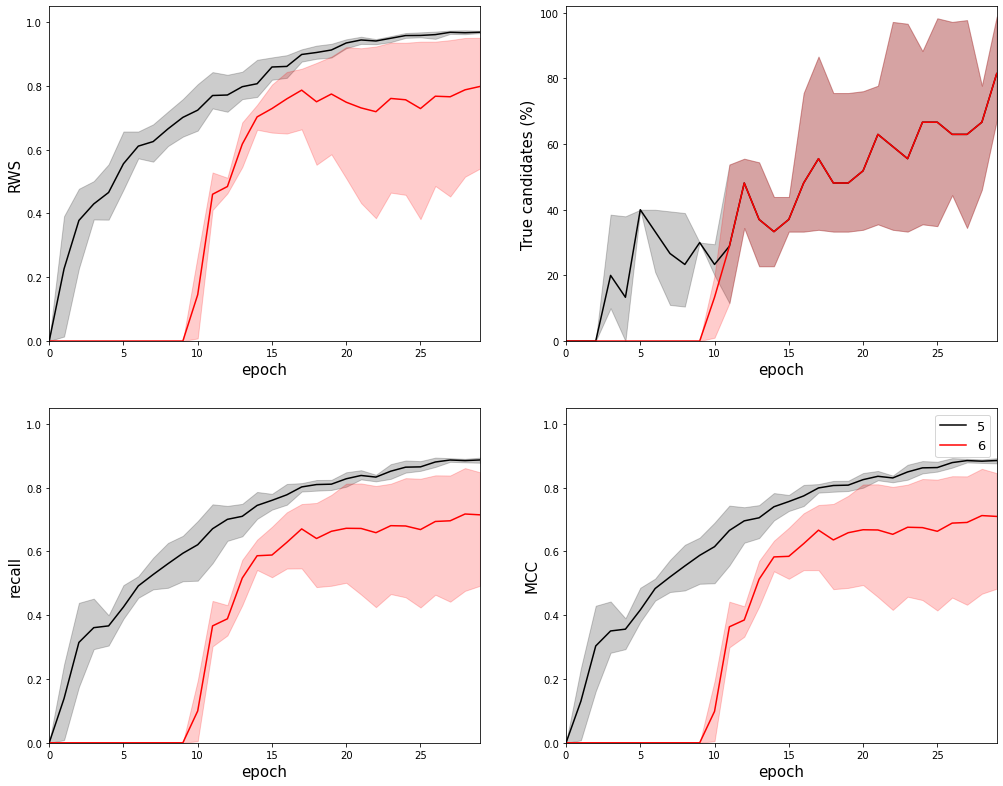

In [8]:
n_night = res_all.shape[2]
xx = np.arange(res_all.shape[2])
xx = xx/xx.max()*n_night

cl = 95
alpha = 0.2
fig,axs = plt.subplots(2,2,figsize=(14,11))

lbls = ['5','6']
clrs = ['k','r','g','b']
metric_names = ['RWS','True candidates (%)','recall','MCC']


for j,jj in enumerate([0,4,1,3]):
    ax = axs[j//2,j%2]
    for  i in range(2):
        ah.analyze_plot(ax, metric=res_all[:,i,:,jj], cl=cl, clr=clrs[i], label=lbls[i], alpha=alpha)

    ax.set_xlabel('epoch',fontsize=15)
    ax.set_ylabel(metric_names[j],fontsize=15)
    ax.set_xlim(0,n_night-1)
    if jj==4:
        ax.set_ylim(0,102)
    else:
        ax.set_ylim(0,1.05)
    
ax.legend(fontsize=13)
plt.subplots_adjust(left=0.05, bottom=0.06, right=0.99, top=0.99, wspace=None, hspace=None)
# plt.savefig('result_{}-{}.jpg'.format(fname,pln),dpi=150)

In [11]:
ntry = 3
n_night = 30
n_questions = 10 # can be an integer or an array of numbers np.random.randint(3,7,n_night)
pre_data_config = {0:500,1:600}
obs_plan = 10*[{0:170,1:200,9:6}]+20*[{0:170,1:200,9:6,5:10}]

path = '/home/vafaeisa/scratch/datasets/prepared/{}.npz'.format(fname)
x0,y0,int_mapper,lbl_mapper = ah.load_npz(path,verbose=1)
x0 = x0/x0.max()

plan_tot = [pre_data_config]+obs_plan

aug = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.04,
    height_shift_range=0.04,
    zoom_range=0.04,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest")

print(pre_data_config)
print(obs_plan[0])

if type(n_questions) is int or type(n_questions) is float:
    if n_questions==1 and type(n_questions) is float:
        assert 0,'Warning, when you choose 1, it should be integer.'
    n_questions = n_night*[n_questions]

if x0.ndim==3:
    n_tot,lx,ly = x0.shape
#     x = x.reshape(n_tot,lx*ly)
    x0 = x0[:,:,:,None]
    nch = 1
elif x0.ndim==4:
    n_tot,lx,ly,nch = x0.shape

if noise!=0:
    x0 += np.random.normal(0,noise,x0.shape)
n_class,class_labels, nums = ah.describe_labels(y0,verbose=0)

(70000, 28, 28) (70000,)
labels/numbers are:
	class0   /  6903
 	class1   /  7877
 	class2   /  6990
 	class3   /  7141
 	class4   /  6824
 	class5   /  6313
 	class6   /  6876
 	class7   /  7293
 	class8   /  6825
 	class9   /  6958

{0: 500, 1: 600}
{0: 170, 1: 200, 9: 6}


In [14]:
res_alls = []
nq_alls = []
res5s = []
res6s = []
    

for nt in range(ntry):
    res1 = []
    res2 = []

    # if save_latent:
    z_mus = []
    lbls = []
    nq_all = []

    x,y = ah.shuffle_data(x0,y0)
    # data 0
    x, y, x_pre, y_pre = ah.data_prepare(x,y,pre_data_config)
    # observation
    obs = ah.Observetory(obs_plan,x,y)

    y = y_pre if givey else None

    ahunt = ah.AHunt(x_pre, y=y, interest=None, aug=aug)
    ahunt.fit(epochs=epochs,ivc=ivc)  

    ahunt0 = ah.AHunt(x_pre, y=y, interest=None, aug=aug)
    ahunt0.fit(epochs=epochs,ivc=ivc)

    if n_night is None: n_night = obs.n_plan
        
    phc = ah.PredictionHistoryChecker()

    for night in range(n_night):
        report = rept.format(nt+1,ntry,int(10*(nt+1)/ntry)*'=',
                             night+1,n_night,int(10*(night+1)/n_night)*'=',
                             ahunt.lm.l2y,ahunt.get_interest())
        print(report,end='\r')
        x_obs,y_obs = obs.new_obs(safemode=1,nightly=nightly)
    #     describe_labels(y_obs,verbose=1)

        # Method 4
        true_guess = ahunt.human_call(x_obs,y_obs,n_questions[night])
        nq_all = len(ahunt.inds_all)

        ahunt.fit(epochs=epochs,ivc=ivc)
#         if ahunt.n_class==4:
#             ahunt.set_interest('5')
        if not '9' in ahunt.lm.yints:
            ahunt.set_interest({'r1':1})
        elif '9' in ahunt.lm.yints and not '5' in ahunt.lm.yints:
            ahunt.set_interest({'r1':5/6,'9':1/6})
        elif '9' in ahunt.lm.yints and '5' in ahunt.lm.yints:
            ahunt.set_interest({'r1':5/8,'9':1/8,'5':2/8})
        else:
            assert 0,'WHAT?!!!'

    #     model_par.append(stds_model(ahunt.clf))
        if '9' in ahunt.lm.yints:
            outlier_ind = 9
            out_obs = y_obs==outlier_ind
            y_true = out_obs.astype(int)
            n_anomaly = np.sum(out_obs)
            ano_inds = np.argwhere(out_obs)[:,0]
            
            scr_ano = ahunt.predict(x_obs,'9')
            trsh = np.sort(scr_ano)[-n_anomaly-1]
            y_pred = scr_ano>trsh
            rws = ah.rws_score(out_obs,scr_ano)
            rc = recall_score(y_true,y_pred)
            pr = precision_score(y_true,y_pred)
            mcc = matthews_corrcoef(y_true,y_pred)
#             nqs = ahunt.nqs[ahunt.lm.l2y['5']]
            res1.append([rws,rc,pr,mcc,100*true_guess/nq_all])
        else:
            res1.append(5*[0])
        
    #     model_par.append(stds_model(ahunt.clf))
        if '5' in ahunt.lm.yints:
            outlier_ind = 5
            out_obs = y_obs==outlier_ind
            y_true = out_obs.astype(int)
            n_anomaly = np.sum(out_obs)
            ano_inds = np.argwhere(out_obs)[:,0]
            
            scr_ano = ahunt.predict(x_obs,'5')
            trsh = np.sort(scr_ano)[-n_anomaly-1]
            y_pred = scr_ano>trsh
            rws = ah.rws_score(out_obs,scr_ano)
            rc = recall_score(y_true,y_pred)
            pr = precision_score(y_true,y_pred)
            mcc = matthews_corrcoef(y_true,y_pred)
#             nqs = ahunt.nqs[ahunt.lm.l2y['9']]
            res2.append([rws,rc,pr,mcc,100*true_guess/nq_all])
        else:
            res2.append(5*[0])
        
    res_alls.append([res1,res2])
    nq_alls.append(nq_all)
    
res_all = np.array(res_alls)
nq_alls = np.array(nq_alls)

# for i in range(2):
#     res_all[:,i,:,4] = 100*res_all[:,i,:,4]/nq_all

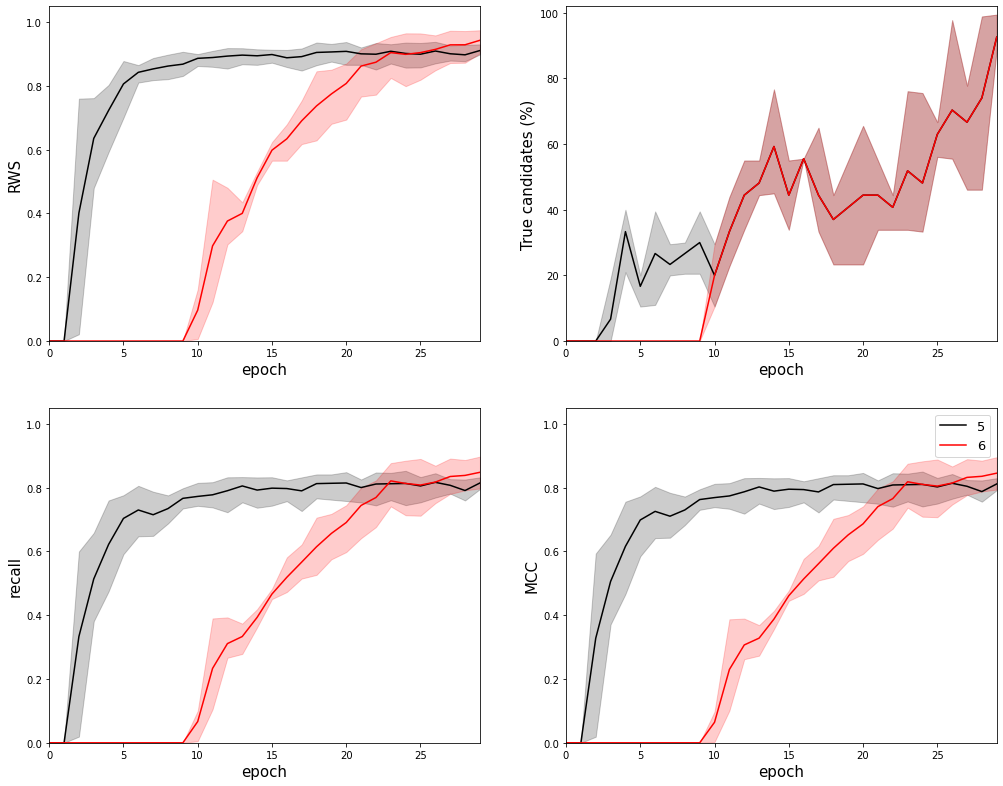

In [15]:
n_night = res_all.shape[2]
xx = np.arange(res_all.shape[2])
xx = xx/xx.max()*n_night

cl = 95
alpha = 0.2
fig,axs = plt.subplots(2,2,figsize=(14,11))

lbls = ['5','6']
clrs = ['k','r','g','b']
metric_names = ['RWS','True candidates (%)','recall','MCC']


for j,jj in enumerate([0,4,1,3]):
    ax = axs[j//2,j%2]
    for  i in range(2):
        ah.analyze_plot(ax, metric=res_all[:,i,:,jj], cl=cl, clr=clrs[i], label=lbls[i], alpha=alpha)

    ax.set_xlabel('epoch',fontsize=15)
    ax.set_ylabel(metric_names[j],fontsize=15)
    ax.set_xlim(0,n_night-1)
    if jj==4:
        ax.set_ylim(0,102)
    else:
        ax.set_ylim(0,1.05)
    
ax.legend(fontsize=13)
plt.subplots_adjust(left=0.05, bottom=0.06, right=0.99, top=0.99, wspace=None, hspace=None)
# plt.savefig('result_{}-{}.jpg'.format(fname,pln),dpi=150)

In [19]:
from time import sleep

In [24]:
for i in range(10):
    print('|{}|\n|{}|'.format(i,i),end='\r\r')
    sleep(0.1)

|0|
|1|
|2|
|2||3|
|4|
|5|
|5||6|
|7|
|8|
|8||9|
|9|

In [11]:
reserved_classes = []
ex = np.array(['A','B','C'])
ex = np.concatenate([reserved_classes,ex])
ex = np.unique(ex)
ex

array(['A', 'B', 'C'], dtype='<U32')

In [ ]:
{}

In [ ]:
    the 1t anomaly is half imporant as the 2nd
    reseved clas is 5 time impatnt than the fist

    2nd anomaly from 10th night
    keep the reserved class

    ratio on the two anomalies

## Results from cluster

In [21]:
ls res/*

res/cifar10-plan1-0.npz   res/cifar10-plan2-4.npz  res/mnist-plan1-17.npz
res/cifar10-plan1-10.npz  res/cifar10-plan2-5.npz  res/mnist-plan1-18.npz
res/cifar10-plan1-11.npz  res/cifar10-plan2-6.npz  res/mnist-plan1-19.npz
res/cifar10-plan1-12.npz  res/cifar10-plan2-7.npz  res/mnist-plan1-1.npz
res/cifar10-plan1-13.npz  res/cifar10-plan2-8.npz  res/mnist-plan1-2.npz
res/cifar10-plan1-14.npz  res/cifar10-plan2-9.npz  res/mnist-plan1-3.npz
res/cifar10-plan1-15.npz  res/mnist-p0-0.npz       res/mnist-plan1-4.npz
res/cifar10-plan1-16.npz  res/mnist-p0-1.npz       res/mnist-plan1-5.npz
res/cifar10-plan1-17.npz  res/mnist-p0-2.npz       res/mnist-plan1-6.npz
res/cifar10-plan1-18.npz  res/mnist-p0-3.npz       res/mnist-plan1-7.npz
res/cifar10-plan1-19.npz  res/mnist-p0-4.npz       res/mnist-plan1-8.npz
res/cifar10-plan1-1.npz   res/mnist-p0-5.npz       res/mnist-plan1-9.npz
res/cifar10-plan1-2.npz   res/mnist-p0-6.npz       res/mnist-plan2-0.npz
res/cifar10-plan1-3.npz   res/mnist-p0-7.npz    

In [11]:
import numpy as np
from glob import glob
import pylab as plt
# from sklearn.ensemble import IsolationForest
# from sklearn.metrics import confusion_matrix
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from sklearn.metrics import recall_score,precision_score,classification_report,confusion_matrix,matthews_corrcoef

import ahunt as ah

In [44]:
fname = 'cifar10'
fname = 'mnist'
pln = 'p1'

res_all = []
res5 = []
res6 = []
nq_all = []
for i in glob('res/{}-{}*'.format(fname,pln)):
    dd = np.load(i)
    res_allp = dd['res_all']
    nq_allp = dd['nq_all']
    res5p = dd['res5']
    res6p = dd['res6']
    
    res_all.append(res_allp)
    nq_all.append(nq_allp)
    res5.append(res5p)
    res6.append(res6p)

res_all = np.array(res_all)
nq_all = np.array(nq_all)
nq_all[nq_all==0] = 1e10
res5 = np.array(res5)
res6 = np.array(res6)
for i in range(4):
    res_all[:,i,:,4] = 100*res_all[:,i,:,4]/nq_all

res_all.shape,res5.shape,res6.shape

((30, 4, 40, 5), (30, 8, 5), (30, 8, 5))

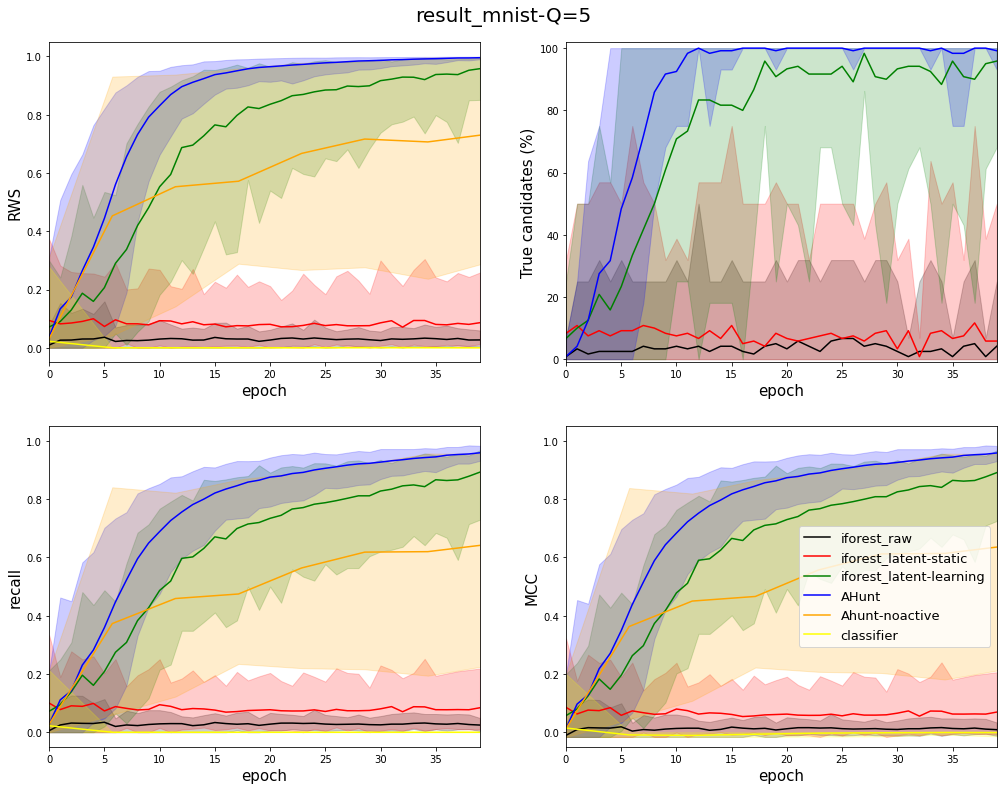

In [45]:
n_night = res_all.shape[2]
xx = np.arange(res_all.shape[2]/res5.shape[2])
xx = xx/xx.max()*n_night

cl = 95
alpha = 0.2
fig,axs = plt.subplots(2,2,figsize=(14,11))

lbls = ['iforest_raw','iforest_latent-static','iforest_latent-learning','AHunt']
clrs = ['k','r','g','b']
metric_names = ['RWS','True candidates (%)','recall','MCC']


for j,jj in enumerate([0,4,1,3]):
    ax = axs[j//2,j%2]
    for  i in range(4):
        ah.analyze_plot(ax, metric=res_all[:,i,:,jj], cl=cl, clr=clrs[i], label=lbls[i], alpha=alpha)
        
    if jj!=4:
        ah.analyze_plot(ax, metric=res5[:,:,jj], x=xx, cl=cl, clr='orange', label='Ahunt-noactive', alpha=alpha)
        ah.analyze_plot(ax, metric=res6[:,:,jj], x=xx, cl=cl, clr='yellow', label='classifier', alpha=alpha)
#             m5 = np.mean(res5[:,jj])
#             ax.plot(np.arange(n_night),n_night*[m5],'b--',label='classifier')

#             m6 = np.mean(res6[:,jj])
#             ax.plot(np.arange(n_night),n_night*[m6],'k--',label='classifier')

    ax.set_xlabel('epoch',fontsize=15)
    ax.set_ylabel(metric_names[j],fontsize=15)
    ax.set_xlim(0,n_night-1)
    if jj==4:
        ax.set_ylim(-1,102)
    else:
        ax.set_ylim(-0.05,1.05)
    
ax.legend(fontsize=13)
plt.subplots_adjust(left=0.05, bottom=0.06, right=0.99, top=0.95, wspace=None, hspace=None)
if pln is 'p0':
    pln = 'Q threshold=0.5'
if pln is 'p1':
    pln = 'Q=5'
plt.suptitle('result_{}-{}'.format(fname,pln),fontsize=20,y=0.995)
plt.savefig('result_{}-{}.jpg'.format(fname,pln),dpi=150)